In [1]:
#импорты
from sklearn.datasets import fetch_california_housing
import pandas as pd

In [2]:
#словарь и смотрим описание датасета и разделим
df=fetch_california_housing(as_frame=True)
X, y = df.data, df.target  # признаки и цель
print(df.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

**Характеристики набора данных:**

:Количество экземпляров: 20640

:Количество атрибутов: 8 числовых, прогнозируемых атрибутов и целевой

:Информация об атрибутах:
- Медианный доход MedInc в группе домов
- Медианный возраст домов в группе домов
- Среднее количество комнат (AveRooms) на домохозяйство
- Среднее количество спален (AveBedrms) на домохозяйство
- Численность населения группы домов
- Среднее количество членов домохозяйства (AveOccup)
- Широта группы домов
- Долгота группы домов

In [3]:
#смотрим сам дф
df = df.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
#!pip install seaborn

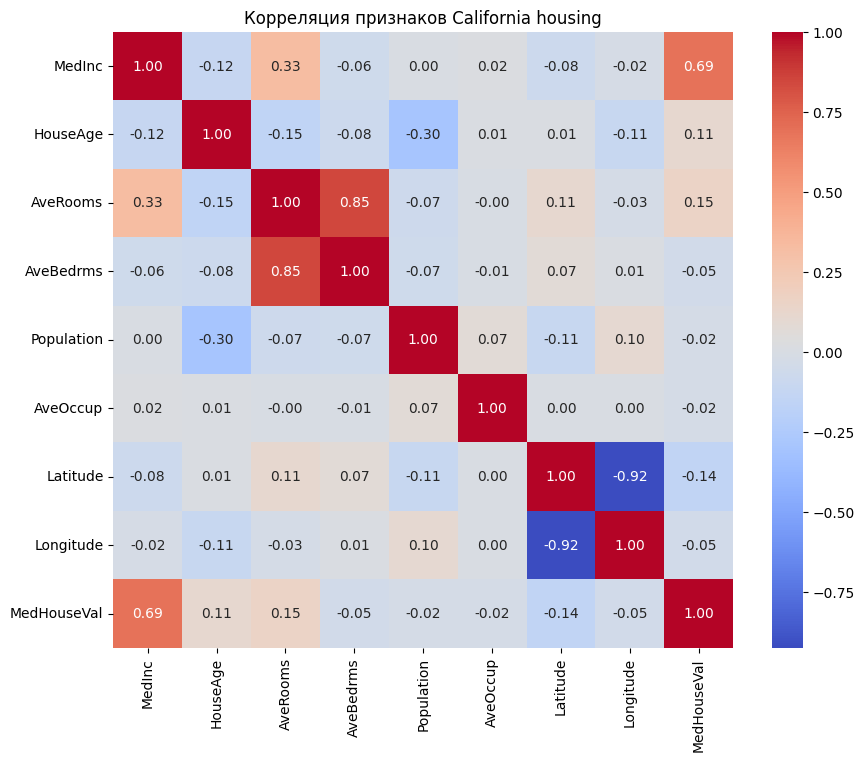

In [5]:
#проверим корреляцию между признаками
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()   # по умолчанию метод Пирсона

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляция признаков California housing")
plt.show()

In [6]:
#Разделяем на обучающую и тестовую выборки с помощью холдаут
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
#!pip install optuna

In [8]:
#Создаём модель Random Forest(линейных зависимостей мало, а рандом выполняется быстрее чем ансамблевые модели)
#подбор гиперпараметров
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def objective(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 800),
        "max_depth": trial.suggest_categorical("max_depth", [None, 6, 10, 14, 18, 22, 26, 30]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error"]),
        "random_state": 42,
        "n_jobs": -1,
    }

    if params["bootstrap"]:
        params["max_samples"] = trial.suggest_float("max_samples", 0.5, 1.0)

    # модель
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    # считаем R² на тесте
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    return r2

In [9]:
#оптимизируем
study = optuna.create_study(direction="maximize", study_name="rf_california")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучший R² (CV):", round(study.best_value, 4))
print("Лучшие параметры:", study.best_params)

[I 2025-09-16 22:40:20,085] A new study created in memory with name: rf_california


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-16 22:48:05,993] Trial 0 finished with value: 0.8039218492190714 and parameters: {'n_estimators': 556, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'absolute_error', 'max_samples': 0.7858954426686484}. Best is trial 0 with value: 0.8039218492190714.
[I 2025-09-16 22:53:26,279] Trial 1 finished with value: 0.7544096748007704 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'absolute_error', 'max_samples': 0.8438089748880941}. Best is trial 0 with value: 0.8039218492190714.
[I 2025-09-16 23:25:08,780] Trial 2 finished with value: 0.674837686773823 and parameters: {'n_estimators': 651, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True, 'criterion': 'absolute_error', 'max_samples': 0.8364481416050584}. Best is trial 0 with value: 0.803921849219

In [10]:
#Обучаем модель
best_params = study.best_params.copy()
best_params.update({"random_state": 42, "n_jobs": -1})
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=26,
                      max_features='log2', min_samples_split=5,
                      n_estimators=640, n_jobs=-1, random_state=42)

In [11]:
#предсказывем
y_pred = model.predict(X_test)

R² - насколько хорошо модель объясняет разброс данных.

MAE - насколько сильно модель ошибается в среднем.

RMSE - чтобы оценить «среднюю ошибку», но с учётом того, что большие ошибки считаются хуже маленьких.

MAPE - ошибки в процентах, а не в «сырых» единицах.

In [13]:
#вычислим все кроме MAPE
import numpy as np

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(((y_test - y_pred) ** 2).mean())

print(f"\nНа тесте: R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")


На тесте: R²=0.8273 | MAE=0.3081 | RMSE=0.4757


In [14]:
#Считаем остатки (residuals = ошибка прогноза)
residuals = y_test - y_pred

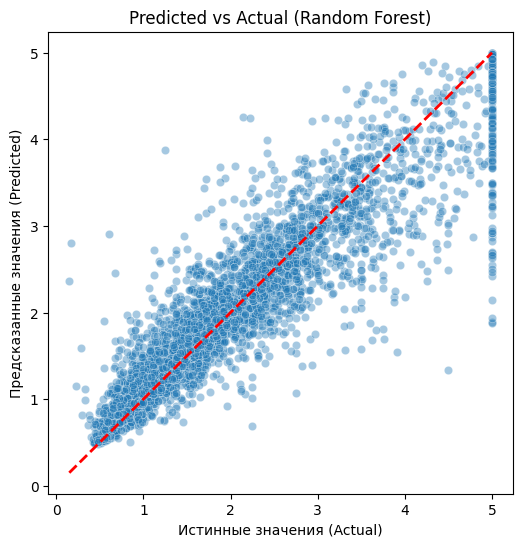

In [15]:
#График Predicted vs Actual (факт против прогноза)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # идеальная линия y=x
plt.xlabel("Истинные значения (Actual)")
plt.ylabel("Предсказанные значения (Predicted)")
plt.title("Predicted vs Actual (Random Forest)")
plt.show()

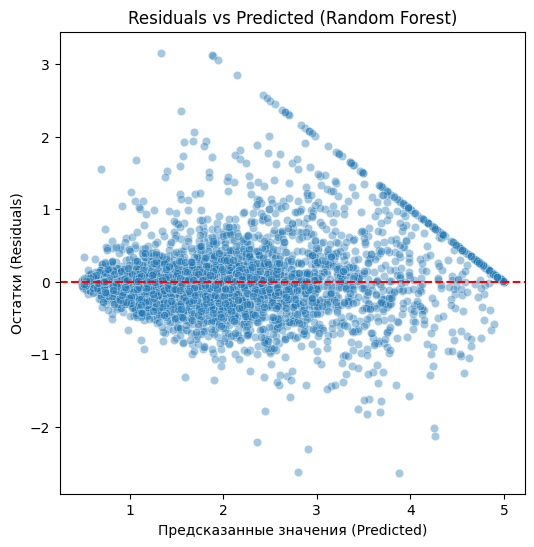

In [16]:
#График Residuals vs Predicted (остатки против прогноза)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.4)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Предсказанные значения (Predicted)")
plt.ylabel("Остатки (Residuals)")
plt.title("Residuals vs Predicted (Random Forest)")
plt.show()